<a href="https://colab.research.google.com/github/Silas-ochieng/Time-series-analysis1/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydot
!pip install pydot_ng
!pip install graphviz


Label: frog


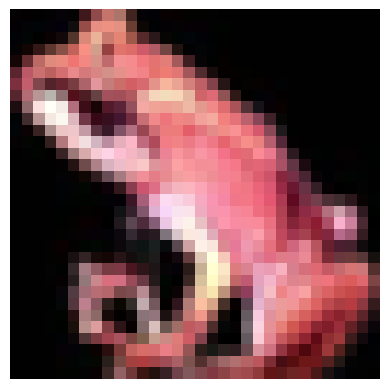

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Sample Image (for visualization)
sample_img = train_images[103]
sample_label = train_labels[103]
print(f"Label: {class_names[sample_label[0]]}")
plt.imshow(sample_img)
plt.axis("off")
plt.show()


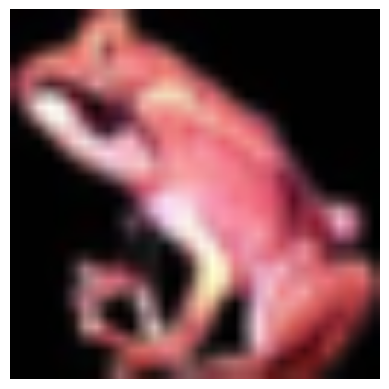

In [3]:
input_size = 244  # Target size for resizing

def format_image(img, box=None):
    # Resize image to fit the input size
    height, width, _ = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size, 3), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    if box:
        # Adjust bounding box (you may modify this for CIFAR-10 if applicable)
        new_box = [int((box[0] - 0.5 * box[2]) * width / r), int((box[1] - 0.5 * box[3]) * height / r),
                   int(box[2] * width / r), int(box[3] * height / r)]
        return new_image, new_box
    return new_image, None

# Example: Format a sample image
temp_img = train_images[103]
temp_img_formated, _ = format_image(temp_img)
plt.imshow(temp_img_formated)
plt.axis("off")
plt.show()


In [ ]:
def data_load(images, labels, image_size=input_size):
    X = []
    Y = []
    for img, label in zip(images, labels):
        # Simulate bounding box for demonstration (since CIFAR-10 doesn't have bounding boxes)
        box = [random.random(), random.random(), random.random(), random.random()]  # Random box for demo
        img_formated, box = format_image(img, box)
        img_formated = img_formated.astype(float) / 255.0
        box = np.asarray(box, dtype=float) / image_size if box else np.zeros(4)
        label_one_hot = np.append(box, label)  # Append class label to the box
        X.append(img_formated)
        Y.append(label_one_hot)

    X = np.array(X)
    X = np.expand_dims(X, axis=3)  # For grayscale images
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    return tf.data.Dataset.from_tensor_slices((X, Y))

train_ds = data_load(train_images, train_labels)
test_ds = data_load(test_images, test_labels)


In [ ]:
def build_model(inputs):
    feature_extractor = build_feature_extractor(inputs)
    model_adaptor = build_model_adaptor(feature_extractor)
    classification_head = build_classifier_head(model_adaptor)
    regressor_head = build_regressor_head(model_adaptor)
    model = tf.keras.Model(inputs=inputs, outputs=[classification_head, regressor_head])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss={'classifier_head': 'categorical_crossentropy', 'regressor_head': 'mse'},
                  metrics={'classifier_head': 'accuracy', 'regressor_head': 'mse'})
    return model

model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 3)))  # For RGB images
model.summary()


In [ ]:
EPOCHS = 50
BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE).repeat()
test_ds = test_ds.batch(BATCH_SIZE).repeat()

history = model.fit(train_ds, steps_per_epoch=len(train_images) // BATCH_SIZE,
                    validation_data=test_ds, validation_steps=1, epochs=EPOCHS, verbose=1)

# Plot training history
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
test_list = list(test_ds.take(20).as_numpy_iterator())

plt.figure(figsize=(20, 10))
for i in range(len(test_list)):
    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]
    predictions = model(image)
    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)
    predicted_label = predictions[0][0]
    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)
    image = image[0]
    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv2.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv2.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())
    plt.title(f"IoU: {IoU:.4f}")
    plt.imshow(image_color)
    plt.axis("off")
plt.show()
